In [1]:
# Install dependencies
!pip install fasttext -q

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from google.colab import drive
import fasttext

# Mount Google Drive
drive.mount('/content/drive')

# Make sure ETSP directory is on the path for module imports
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ETSP/utils')
from prepare_dataset import make_datasets

# Disable WandB
os.environ["WANDB_DISABLED"] = "true"

# Set file path and dialects
file_path = '/content/drive/MyDrive/Colab Notebooks/ETSP/sentences_ch_de_transcribed.json'
dialects = ['ch_sg', 'ch_be', 'ch_gr', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_ag', 'ch_lu']

# Load datasets and label mappings
train_dataset, val_dataset, test_dataset, dialect2label, _, _, _ = make_datasets(file_path, dialects)
label2dialect = {i: d for d, i in dialect2label.items()}

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))
print("Label mapping:", label2dialect)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Mounted at /content/drive
Number of training examples: 16184
Number of validation examples: 2024
Number of test examples: 2024
Label mapping: {0: 'ch_sg', 1: 'ch_be', 2: 'ch_gr', 3: 'ch_zh', 4: 'ch_vs', 5: 'ch_bs', 6: 'ch_ag', 7: 'ch_lu'}


In [2]:
# Print class distribution
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(val_dataset)
test_df = pd.DataFrame(test_dataset)

print("Train distribution:")
print(train_df['label'].value_counts().sort_index())

print("\nValidation distribution:")
print(val_df['label'].value_counts().sort_index())

print("\nTest distribution:")
print(test_df['label'].value_counts().sort_index())

Train distribution:
label
0    2023
1    2023
2    2023
3    2023
4    2023
5    2023
6    2023
7    2023
Name: count, dtype: int64

Validation distribution:
label
0    253
1    253
2    253
3    253
4    253
5    253
6    253
7    253
Name: count, dtype: int64

Test distribution:
label
0    253
1    253
2    253
3    253
4    253
5    253
6    253
7    253
Name: count, dtype: int64


In [3]:
# Prepare data files for fastText (supervised format: __label__<id> text)

def to_fasttext_format(df, text_col="text", label_col="label", out_path="data.txt"):
    with open(out_path, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            label_id = int(row[label_col])
            text = str(row[text_col]).replace("\n", " ").strip()
            if not text:
                continue
            line = f"__label__{label_id} {text}\n"
            f.write(line)
    return out_path

train_path = to_fasttext_format(train_df, out_path="train.txt")
val_path   = to_fasttext_format(val_df,   out_path="val.txt")
test_path  = to_fasttext_format(test_df,  out_path="test.txt")

print("fastText files created:")
print(" -", train_path)
print(" -", val_path)
print(" -", test_path)

fastText files created:
 - train.txt
 - val.txt
 - test.txt


In [4]:
# Train fastText supervised model

model = fasttext.train_supervised(
    input=train_path,
    lr=0.5,
    epoch=25,
    wordNgrams=2,
    dim=100,
    loss="hs"  # hierarchical softmax
)

# Save model (optional)
model_path = "fasttext_swissdial.bin"
model.save_model(model_path)
print("Model saved to:", model_path)

Model saved to: fasttext_swissdial.bin


In [5]:
# Evaluate model on validation and test sets using fastText metrics

print("Validation set performance (fastText):")
val_n, val_precision, val_recall = model.test(val_path)
val_f1 = 2 * val_precision * val_recall / (val_precision + val_recall + 1e-12)
print(f"  Samples:   {val_n}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1:        {val_f1:.4f}")

print("\nTest set performance (fastText):")
test_n, test_precision, test_recall = model.test(test_path)
test_f1 = 2 * test_precision * test_recall / (test_precision + test_recall + 1e-12)
print(f"  Samples:   {test_n}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1:        {test_f1:.4f}")

Validation set performance (fastText):
  Samples:   2024
  Precision: 0.7485
  Recall:    0.7485
  F1:        0.7485

Test set performance (fastText):
  Samples:   2024
  Precision: 0.7352
  Recall:    0.7352
  F1:        0.7352


Classification report (test set):
              precision    recall  f1-score   support

       ch_sg       0.72      0.58      0.64       253
       ch_be       0.67      0.83      0.74       253
       ch_gr       0.73      0.78      0.75       253
       ch_zh       0.71      0.64      0.68       253
       ch_vs       0.80      0.87      0.83       253
       ch_bs       0.70      0.56      0.62       253
       ch_ag       0.78      0.60      0.68       253
       ch_lu       0.66      0.88      0.75       253

    accuracy                           0.72      2024
   macro avg       0.72      0.72      0.71      2024
weighted avg       0.72      0.72      0.71      2024



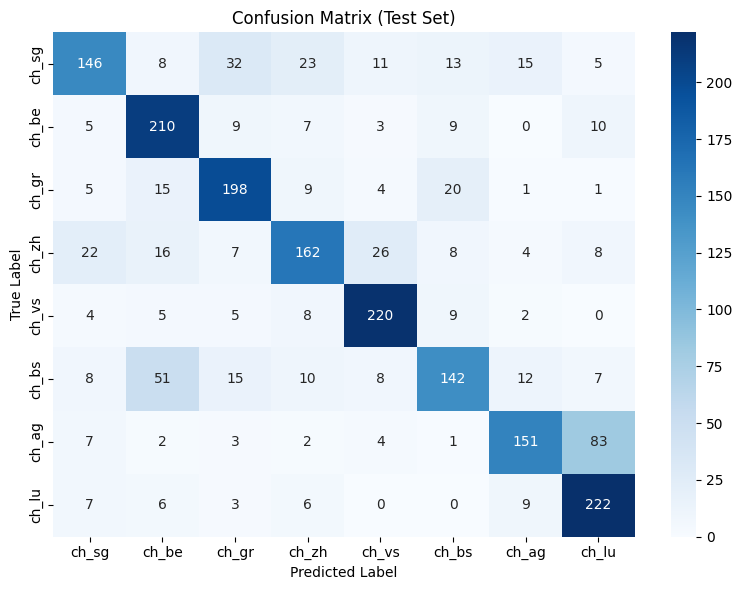

In [9]:
# Detailed evaluation on test set: classification report + confusion matrix

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ground-truth labels
y_true = test_df["label"].astype(int).to_numpy()

# Predictions
y_pred = []
for text in test_df["text"]:
    txt = str(text).replace("\n", " ").strip()

    if not txt:
        y_pred.append(0)
        continue

    # model.f.predict returns list[(probability, label)]
    # label may be bytes OR str depending on fastText version
    predictions = model.f.predict(txt, 1, 0.0, "utf-8")

    if len(predictions) == 0:
        y_pred.append(0)
        continue

    prob, label_raw = predictions[0]

    # Ensure label is a Python string
    if isinstance(label_raw, bytes):
        label_str = label_raw.decode("utf-8")
    else:
        label_str = label_raw

    # Extract numeric label
    try:
        label_id = int(label_str.replace("__label__", ""))
    except Exception:
        label_id = 0

    y_pred.append(label_id)

y_pred = np.array(y_pred)

# Map labels to dialect names
num_labels = len(label2dialect)
target_names = [label2dialect[i] for i in range(num_labels)]

print("Classification report (test set):")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()